# Figures 2 and 5 for gather paper

In [1]:
%matplotlib inline
import pylab
import pandas as pd

TODO:
- [ ] fix number on x axis for fig5

## Preparation: load genome-grist summary CSVs

In [16]:
class SampleDFs:
    def __init__(self, name, all_df, left_df, gather_df, names_df):
        self.name = name
        self.all_df = all_df
        self.left_df = left_df
        self.gather_df = gather_df
        self.names_df = names_df

def load_sample_dfs(name, sample_id, subsample_to=None, debug=False):
    print(f'loading sample {sample_id}')
    # load mapping CSVs
    all_df = pd.read_csv(f'inputs/minimap/depth/{sample_id}.summary.csv')
    left_df = pd.read_csv(f'inputs/leftover/depth/{sample_id}.summary.csv')

    # load gather CSV
    gather_df = pd.read_csv(f'inputs/genbank/{sample_id}.x.genbank.gather.csv')

    # names!
    names_df = pd.read_csv(f'inputs/genbank/{sample_id}.genomes.info.csv')

    # connect gather_df to all_df and left_df using 'genome_id'
    def fix_name(x):
        return "_".join(x.split('_')[:2]).split('.')[0]

    gather_df['genome_id'] = gather_df['name'].apply(fix_name)
    names_df['genome_id'] = names_df['acc'].apply(fix_name)

    # this ensures that only rows that share genome_id are in all the dataframes
    in_gather = set(gather_df.genome_id)
    if debug:
        print(f'{len(in_gather)} in gather results')
    in_left = set(left_df.genome_id)
    if debug:
        print(f'{len(in_left)} in leftover results')

    in_both = in_left.intersection(in_gather)
    if debug:
        print(f'{len(in_both)} in both')
        print('diff gather example:', list(in_gather - in_both)[:5])
        print('diff left example:', list(in_left - in_both)[:5])
        
    assert not in_gather - in_both
    assert not in_left - in_both

    all_df = all_df[all_df.genome_id.isin(in_both)]
    left_df = left_df[left_df.genome_id.isin(in_both)]
    gather_df = gather_df[gather_df.genome_id.isin(in_both)]
    names_df = names_df[names_df.genome_id.isin(in_both)]

    # reassign index now that we've maybe dropped rows
    all_df.index = range(len(all_df))
    left_df.index = range(len(left_df))
    gather_df.index = range(len(gather_df))
    names_df.index = range(len(names_df))

    assert len(all_df) == len(gather_df)
    assert len(left_df) == len(gather_df)
    assert len(names_df) == len(gather_df)
    assert len(names_df) == len(in_both)

    #in_left

    # re-sort left_df and all_df to match gather_df order, using matching genome_id column
    all_df = all_df.set_index("genome_id")
    all_df = all_df.reindex(index=gather_df["genome_id"])
    all_df = all_df.reset_index()

    left_df = left_df.set_index("genome_id")
    left_df = left_df.reindex(index=gather_df["genome_id"])
    left_df = left_df.reset_index()

    #left_df["mapped_bp"] = (1 - left_df["percent missed"]/100) * left_df["genome bp"]
    #left_df["unique_mapped_coverage"] = left_df.coverage / (1 - left_df["percent missed"] / 100.0)

    names_df = names_df.set_index("genome_id")
    names_df = names_df.reindex(index=gather_df["genome_id"])
    names_df = names_df.reset_index()

    # subsample? take top N...
    if subsample_to:
        left_df = left_df[:subsample_to]
        all_df = all_df[:subsample_to]
        gather_df = gather_df[:subsample_to]
        names_df = names_df[:subsample_to]

    sample_df = SampleDFs(name, all_df, left_df, gather_df, names_df)
    return sample_df

SUBSAMPLE_TO = 36
podar_mock = load_sample_dfs('podar mock', 'SRR606249', subsample_to=SUBSAMPLE_TO,)
oil_well = load_sample_dfs('oil well', 'SRR1976948', subsample_to=SUBSAMPLE_TO)
gut = load_sample_dfs('gut', 'p8808mo11', subsample_to=SUBSAMPLE_TO)
zymo_mock = load_sample_dfs('zymo mock', 'SRR12324253', subsample_to=SUBSAMPLE_TO)

loading sample SRR606249
loading sample SRR1976948
loading sample p8808mo11
loading sample SRR12324253


## Figure 2: K-mer decomposition of a metagenome into constituent genomes. 

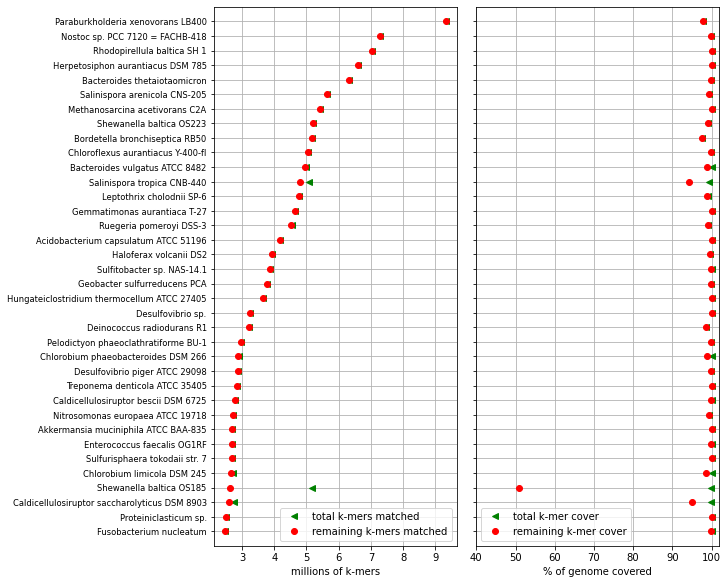

In [3]:

fig, (ax1, ax2) = pylab.subplots(1, 2, figsize=(10, 8), constrained_layout=True)

#pylab.plot(left_df.covered_bp / 1e6, left_df.iloc[::-1].index, 'b.', label='mapped bp to this genome')
ax1.plot(podar_mock.gather_df.intersect_bp / 1e6, podar_mock.gather_df.iloc[::-1].index, 'g<',
         label='total k-mers matched')
ax1.plot(podar_mock.gather_df.unique_intersect_bp / 1e6, podar_mock.gather_df.iloc[::-1].index, 'ro',
         label='remaining k-mers matched')

positions = list(podar_mock.gather_df.index)
labels = list(reversed(podar_mock.names_df.ncbi_tax_name))

ax1.set_yticks(positions)
ax1.set_yticklabels(labels, fontsize='small')

ax1.set_xlabel('millions of k-mers')
ax1.axis(ymin=-1, ymax=SUBSAMPLE_TO)
ax1.legend(loc='lower right')
ax1.grid(True, axis='both')

ax2.plot(podar_mock.gather_df.f_match_orig * 100, podar_mock.gather_df.iloc[::-1].index, 'g<', label='total k-mer cover')
ax2.plot(podar_mock.gather_df.f_match * 100, podar_mock.gather_df.iloc[::-1].index, 'ro', label='remaining k-mer cover')
ax2.set_yticks(positions)
ax2.set_yticklabels([])
ax2.set_xlabel('% of genome covered')
ax2.legend(loc='lower left')
ax2.axis(xmin=40, xmax=102)
ax2.axis(ymin=-1, ymax=SUBSAMPLE_TO)
ax2.grid(True)

#fig.tight_layout()

None
fig.savefig('/tmp/xxx.svg')
# mv /tmp/xxx.svg content/images/gathergram-SRR606249.hashes.svg 


## Figure 5: Hash-based k-mer decomposition of a metagenome into constituent genomes compares well to bases covered by read mapping. 

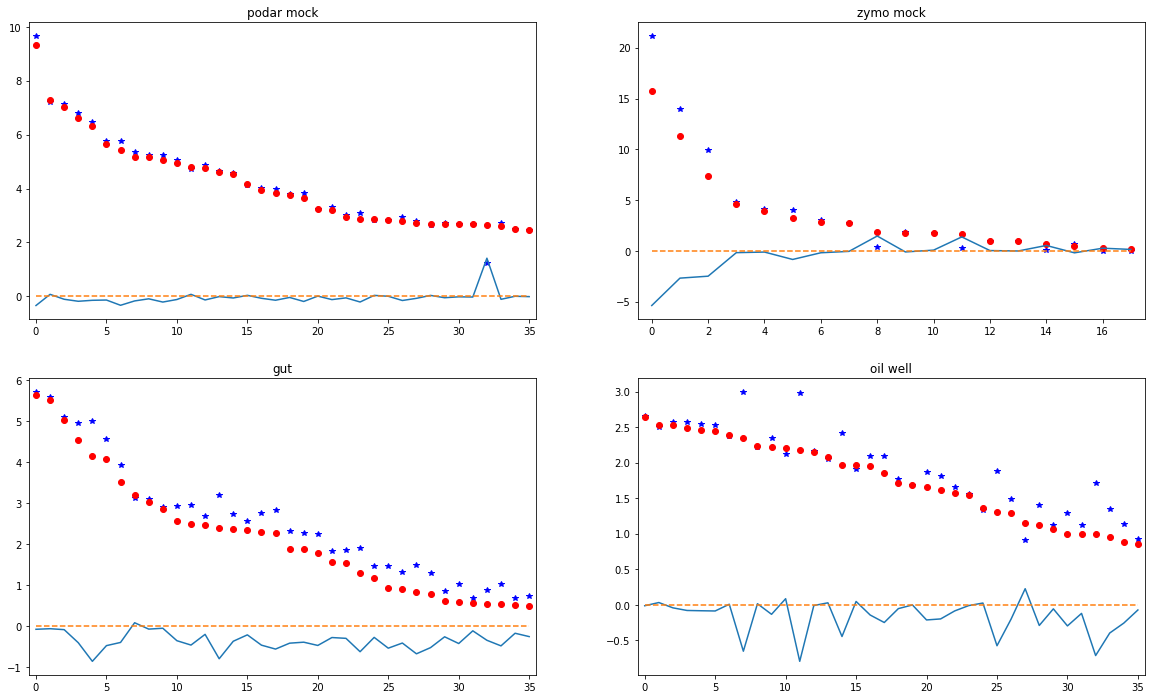

In [19]:
# @CTB fix number on x axis, too!
import matplotlib.pyplot as plt
fig, axes = plt.subplots(figsize=(20, 12), nrows=2, ncols=2)

samples = (podar_mock, zymo_mock, gut, oil_well)

for ax, sample in zip(axes.flat, samples):
    ax.plot(sample.left_df.index, sample.left_df.covered_bp / 1e6, 'b*', label='genome bases covered by mapped reads')
    ax.plot(sample.gather_df.index, sample.gather_df.unique_intersect_bp / 1e6, 'ro', label='remaining genome hashes in metagenome')

    ax.plot(sample.gather_df.index, (sample.gather_df.unique_intersect_bp - sample.left_df.covered_bp) / 1e6,  
               '-', label='difference b/t covered bp and hashes')
    ax.plot(sample.gather_df.index, [0]*len(sample.gather_df), '--')

    positions = list(sample.gather_df.index)
    labels = list(reversed(sample.names_df.ncbi_tax_name))
    #pylab.xticks(positions, labels, fontsize='small')

    ax.axis(xmin=-0.5, xmax=len(sample.gather_df.index) - 0.5)
    #ax.set_xlabel('genome rank (ordered by gather results)')
    #ax.set_ylabel('number per genome (million)')
    #ax.legend(loc='upper right')
    ax.set_title(sample.name)

#pylab.tight_layout()


pylab.savefig('/tmp/yyy.svg')
